<div dir="rtl" style="text-align: right;">

### **تمرین سری دوم**
### **هوش مصنوعی و یادگیری ماشین (رگرسیون)**
### **محمدمهدی تویسرکانی**
### **تاریخ تحویل : 1404/01/28**

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 82 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Order            2930 non-null   int64  
 1   PID              2930 non-null   int64  
 2   MS SubClass      2930 non-null   int64  
 3   MS Zoning        2930 non-null   object 
 4   Lot Frontage     2440 non-null   float64
 5   Lot Area         2930 non-null   int64  
 6   Street           2930 non-null   object 
 7   Alley            198 non-null    object 
 8   Lot Shape        2930 non-null   object 
 9   Land Contour     2930 non-null   object 
 10  Utilities        2930 non-null   object 
 11  Lot Config       2930 non-null   object 
 12  Land Slope       2930 non-null   object 
 13  Neighborhood     2930 non-null   object 
 14  Condition 1      2930 non-null   object 
 15  Condition 2      2930 non-null   object 
 16  Bldg Type        2930 non-null   object 
 17  House Style   

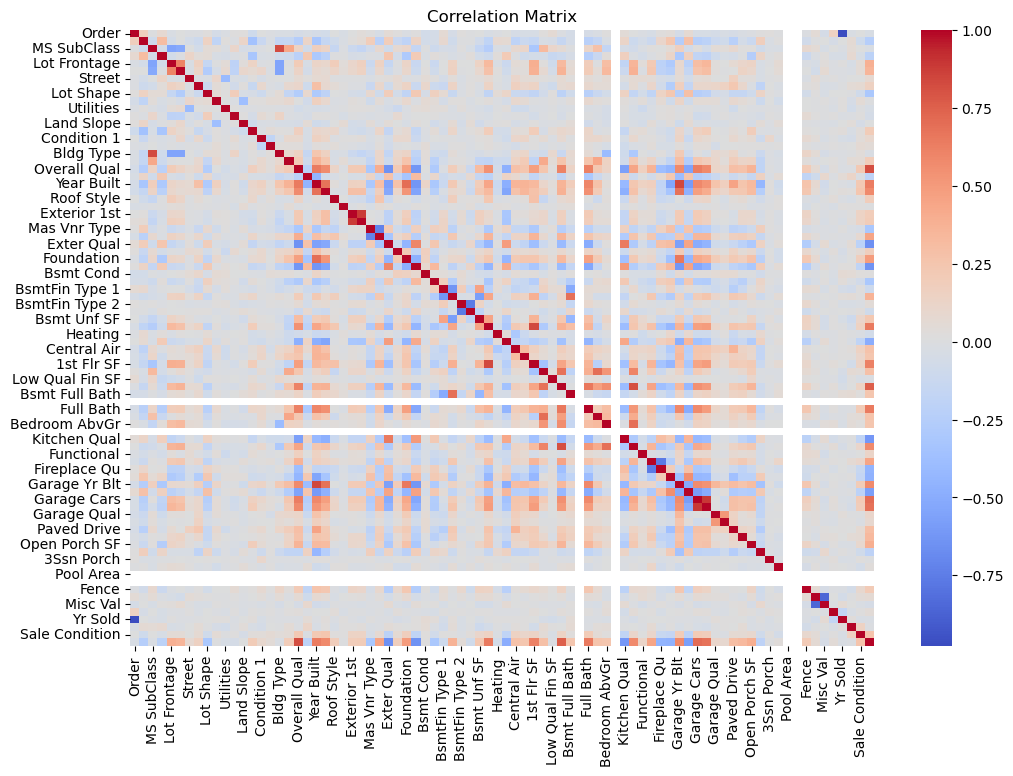

Top correlated features: Index(['Overall Qual', 'Gr Liv Area', 'Garage Cars', 'Garage Area',
       'Exter Qual'],
      dtype='object')


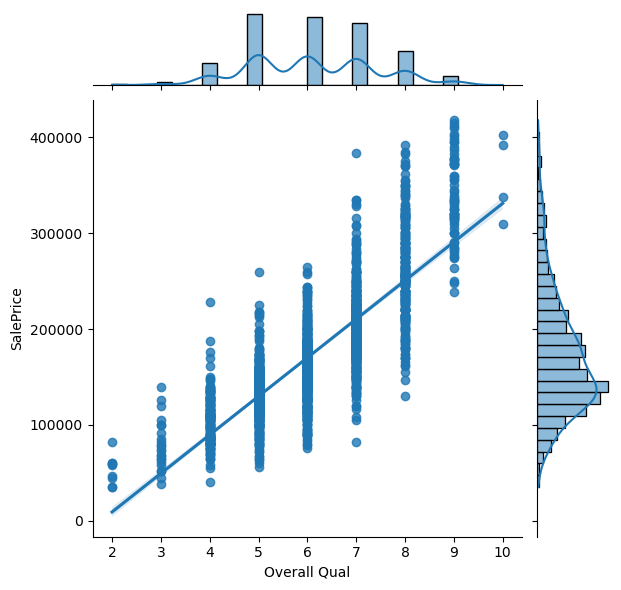

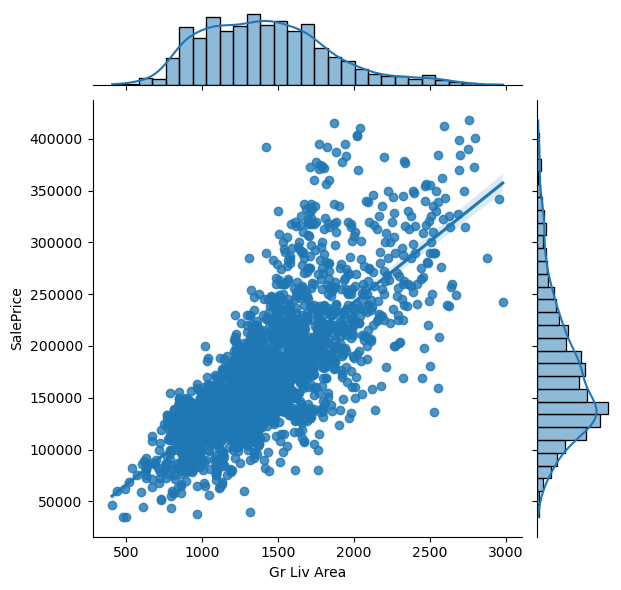

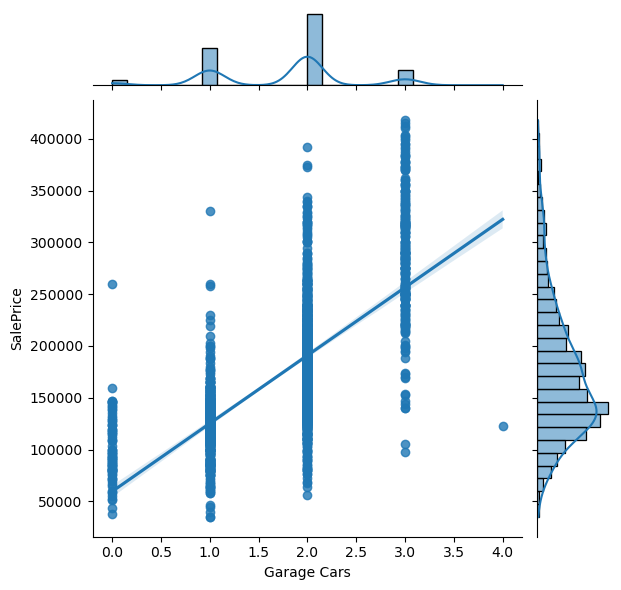

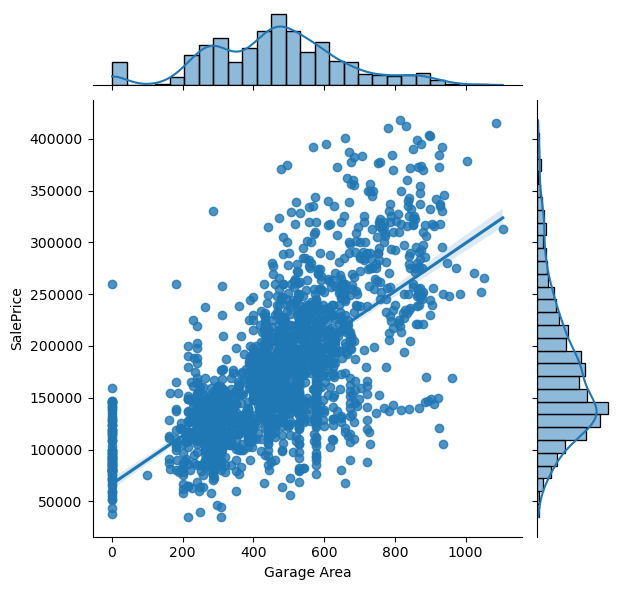

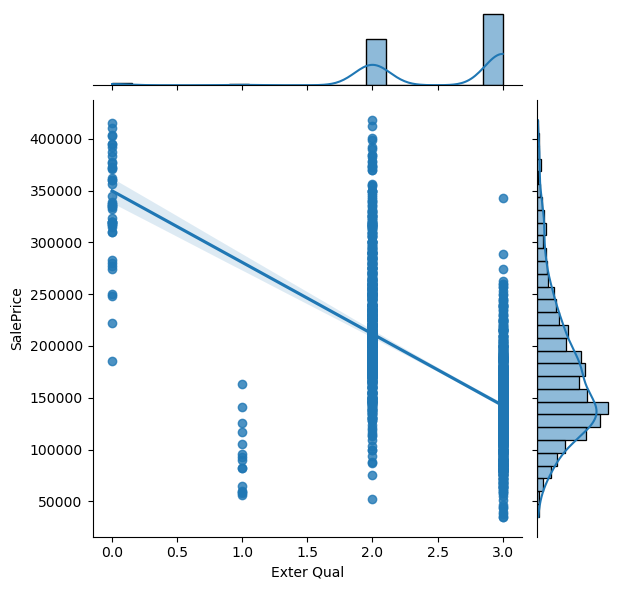

Selected Features: Index(['Overall Qual', 'Year Built', 'Exter Qual', 'Bsmt Qual',
       'Total Bsmt SF', '1st Flr SF', 'Gr Liv Area', 'Full Bath',
       'Garage Cars', 'Garage Area'],
      dtype='object')
Linear Regression - RMSE: 24693.81524669154, R²: 0.8720629110932115
Lasso Regression - RMSE: 24693.819430292417, R²: 0.8720628677432669
Ridge Regression - RMSE: 24694.07012234638, R²: 0.8720602700904124
Polynomial Regression (degree=2) - RMSE: 21188.391250410514, R²: 0.9058075609303414


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import zscore
from sklearn.preprocessing import LabelEncoder

df = pd.read_csv("Housing.csv")

df.info()

df.fillna(df.median(numeric_only=True), inplace=True)

df = df[(np.abs(zscore(df.select_dtypes(include=[np.number]))) < 3).all(axis=1)]

print(df.describe())

label_encoders = {}
for col in df.select_dtypes(include=["object"]).columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

plt.figure(figsize=(12, 8))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=False, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

top_corr_features = corr_matrix['SalePrice'].abs().sort_values(ascending=False)[1:6].index
print("Top correlated features:", top_corr_features)

for feature in top_corr_features:
    sns.jointplot(data=df, x=feature, y='SalePrice', kind='reg')
    plt.show()

X = df.drop(columns=['SalePrice'])
y = df['SalePrice']
selector = SelectKBest(score_func=f_regression, k=10)
X_selected = selector.fit_transform(X.select_dtypes(include=[np.number]), y)
selected_features = X.select_dtypes(include=[np.number]).columns[selector.get_support()]
print("Selected Features:", selected_features)

X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.25, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

models = {
    "Linear Regression": LinearRegression(),
    "Lasso Regression": Lasso(alpha=0.1),
    "Ridge Regression": Ridge(alpha=1.0),
    "Polynomial Regression (degree=2)": PolynomialFeatures(degree=2)
}

for name, model in models.items():
    if name == "Polynomial Regression (degree=2)":
        poly = PolynomialFeatures(degree=2)
        X_train_poly = poly.fit_transform(X_train)
        X_test_poly = poly.transform(X_test)
        poly_model = LinearRegression()
        poly_model.fit(X_train_poly, y_train)
        y_pred = poly_model.predict(X_test_poly)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    print(f"{name} - RMSE: {rmse}, R²: {r2}")
